# Exploring Exotic Phases of Magnetic Materials Near Instabilities

For many Hamiltonians, there are regions in the parameter space of the exchange interactions that defy classical or semi-classical description. This phenomenon often arises from the presence of long range entanglement that prevents understanding and prediction of properties of such phases. The computational complexity required to enable the study of these exotic phases is the ability to compute specified observables either from the ground state or after simulating the time-dynamics for a spin Hamiltonian defined on a lattice.

The motivation for this research is both for fundamental physics and technology. On the fundamental side, interacting quantum spin systems are some of the simplest models in many-body quantum physics. On the technological side, real materials with interacting magnetic atoms can give unique and useful properties like giant magnetoresistance and, possibly in the future - topological qubits. Essentially, quantum magnetic materials offer the ability to harness quantum mechanics at higher temperatures and longer length-scales that is possible with other quantum devices.

In this notebook, we will present two applications to enable the completition of short-term research goals for a given material and set of models. The two applications that we will be investigating are the following:
1. compute the magnetic ground state of interacting magnetic spins where entanglement becomes long ranged and semiclassical methods fail
2. compute the magnetic dynamics of model spin systems for comparisons with experimental data from neutron scattering experiments

### Ground State of Systems Near Instabilities

Spin ground states can be calculated by classical and semiclassical methods, but these methods fail when the exchange interactions are tuned to an instability: either an exotic magnetic phase which defies semiclassical description, or a phase boundary between two types of magnetic order. In this case, its unclear what the ground state is and where the phase boundaries lie. 

As such, the main objective in this section is to compute the magnetic ground state of spins at or near an instability, and determine whether an additional non-trivial magnetic phase exists at this point.

There are three main steps to completing this objective:
1. Define a hamiltonian in the following form: $ \ H = \sum_{ij} S_iJ_{ij}S_j $ where $ S_i$ are quantum spin operators and $J_{ij}$ is a second rank tensor governing the interactions between spins
2. Prepare an initial state believed to have non-vanishing overlap with the actual ground state of the input Hamiltonian. This is believed to be reasonably achieved by using the classical Hartree-Fock approximation to prepare a product state with low energy and applying local unitary rotations to the $|0...0\rangle$ state
3. Perform Ground State Energy Estimation on the Hamiltonian on a quantum computer to estimate the ground state energies within an energy accuracy of $\approx |J_1|/100$

For the first experiment, we will be investigating a 2D square lattice where it's hamiltonian has been transformed into the $J_1 - J_2$ Heisenberg model. The Hamiltonian of the model is:
$$H = J_1 \sum_{<i, j>} S_i \cdot S_j + J_2 \sum_{<<i, j>>} S_i \cdot S_j$$
where $S_i = (S^x_i, S^y_i, S^z_i)$ denotes the spin operator acting on a spin-$\frac{1}{2}$ at site i. The summations are taken over nearest-neigher (<i, j>) and next-nearest-neighbor (<<i, k>>) pairs. This model, which comprises nearest-neighboring ($J_1$, the energy unit) and next-nearest-neighboring ($J_2$) exchange interactions, exhibits a delicate interplay between competing magnetic interactions.



In [15]:
import time

import numpy as np

from networkx import (
    Graph,
    draw,
    spring_layout,
    draw_networkx_edge_labels,
    get_edge_attributes,
    draw_networkx_edge_labels
)

import matplotlib.pyplot as plt

from qca.utils.algo_utils import estimate_trotter, gsee_resource_estimation
from qca.utils.hamiltonian_utils import (
    flatten_nx_graph,
    nx_heisenberg_terms,
    nx_triangle_lattice,
    pyliqtr_hamiltonian_to_openfermion_qubit_operator
)

from pyLIQTR.utils.Hamiltonian import Hamiltonian as pyH

Consider the following code to visualize how the frustrated lattice looks like. For this demonstation, we will be using a lattice size of 5x5.

In [16]:
def gen_king_graph(lattice_size: int, j1: str, j2: str) -> Graph:
    '''
    Given some lattice size, nearest-neighbor interaction, and next-nearest-neighbor interaction,
    we define a graph that corresponds to the J1-J2 Heisenberg model.
    '''
    graph = Graph()

    for i in range(lattice_size):
        for j in range(lattice_size):
            graph.add_node((i,j))

    for i in range(lattice_size):
        for j in range(lattice_size):
            directions = [(0,1), (1,1), (1,0), (1,-1)]
            for di, dj in directions:
                neighbor_i = i + di
                neighbor_j = j + dj
                if 0 <= neighbor_i < lattice_size and 0 <= neighbor_j < lattice_size:
                    if abs(di) + abs(dj) == 1:
                        weight = j1
                    if abs(di) + abs(dj) == 2:
                        weight = j2
                    graph.add_edge((i,j), (neighbor_i, neighbor_j), weight=weight)
    
    return graph


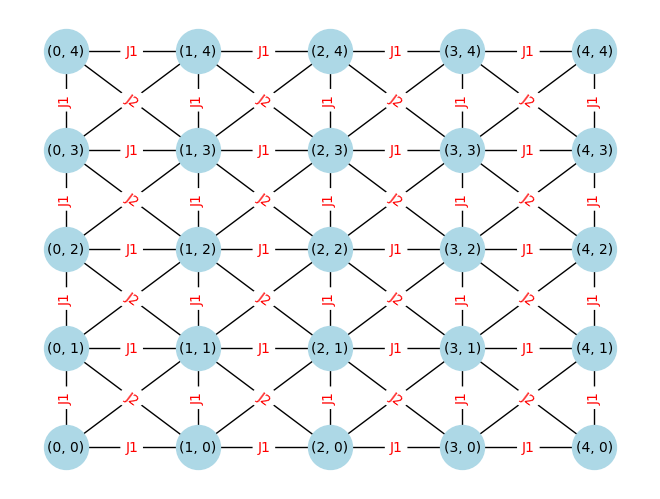

In [17]:
lattice_size = 5

king_graph = gen_king_graph(
    lattice_size=lattice_size,
    j1=f'J1',
    j2=f'J2'
)

pos = {node: node for node in king_graph.nodes()}
edge_labels = get_edge_attributes(king_graph, 'weight')
draw(king_graph, pos, with_labels=True, node_size=1000, font_size=10, node_color = 'lightblue', font_color = 'black')
draw_networkx_edge_labels(king_graph, pos, edge_labels=edge_labels, font_color='red')
plt.show()

In this experiment, we turn the exchange interactions of the Heisenberg model on a square lattice to an instability $\frac{J_2}{J_1} = \frac{1}{2}$. Given this, we set $J_1 = 1$ as the energy unit. Through this, we can clearly see that $J_2 = \frac{1}{2}$. With this instability in place, we can perform Quantum Phase Estimation (QPE) to estimate the ground state within some number of bits of precision. 

Recently, there have been new improvements for performing ground state energy estimatiom from pyLIQTR. However, as pyLIQTR currently does not have the flexibility to encode this specific problem instance, we will be reverting to the old way of performing GSEE, i.e, using a trotterized subprocess for QPE for estimating the ground state of the quantum system.
- Note that the new approach explores a qubitized ground-state energy estimation algorithm that queries powers of a qubitized walk W operator in lieu of a standard time evolution oracle. This oracle contains a block encoding of our Hamiltonian H, which is handled using a $Prepare^{-1} \cdot Select \cdot Prepare$ oracle sequence. The eigenphases $\phi_{k}$ of W have a simple functional relation with the eigenenergies $E_k$ of H, allowing us to extract the latter using phase estimation: $\phi_k \approx exp[iarcos(E_k/\alpha)\cdot \hat{Y}]$ . Once we are able to encode our problem approriately, a study will be performed between the two algorithms to compare the resource estimates from such execution. 

We will also investigate the J1-J2 Heisenberg model on an antiferromagnetic triangular lattice. Similarly, for the triangular lattice, we set $J_1 = 1$ and consider only $J_2 > 0$. For this experiment, we are setting $\frac{J_2}{J_1}$ = $\frac{1}{8}$. Consider the code below to visualize how the frustrated triangular lattice looks like.

In [18]:
def generate_square_heisenberg_hamiltonian(lattice_size:int, j1: float, j2: float):
    '''
    Given some lattice size and j1 and j2 arguments, we will generate its corresponding
    Hamiltonian. 
    '''
    graph = gen_king_graph(lattice_size, j1, j2)
    flat_graph = flatten_nx_graph(graph)
    H = nx_heisenberg_terms(flat_graph)
    return H

square_j1 = 1
square_j2 = 1/2
square_heisenberg_qubit_hamiltonian = generate_square_heisenberg_hamiltonian(
    lattice_size=lattice_size,
    j1=square_j1,
    j2=square_j2
)

{((0, 0), (1, 0)): Text(-0.19514009082261508, 0.6927395549709421, '1'),
 ((0, 0), (0, 1)): Text(0.13704481065734653, 0.7056984923842029, '1'),
 ((0, 0), (1, 1)): Text(-0.023774917341547352, 0.5674300331167816, '0.125'),
 ((0, 1), (1, 1)): Text(0.14801415826468878, 0.44419012659627377, '1'),
 ((0, 1), (0, 2)): Text(0.49439046242799756, 0.43752716884539544, '1'),
 ((0, 1), (1, 2)): Text(0.3380274340978031, 0.2983792170019366, '0.125'),
 ((0, 2), (1, 2)): Text(0.5235878988807918, 0.15345749781423823, '1'),
 ((0, 2), (0, 3)): Text(0.8399786243224898, 0.16643636561393982, '1'),
 ((0, 2), (1, 3)): Text(0.6917150323020449, 0.02726937369585114, '0.125'),
 ((0, 3), (1, 3)): Text(0.8517482671111665, -0.09889481335538974, '1'),
 ((1, 0), (2, 0)): Text(-0.5282571574494274, 0.3988531020660482, '1'),
 ((1, 0), (1, 1)): Text(-0.1841675893940804, 0.4312247522918071, '1'),
 ((1, 0), (2, 1)): Text(-0.36143809407268046, 0.27185917131363246, '0.125'),
 ((1, 1), (2, 1)): Text(-0.19007563887854428, 0.146546

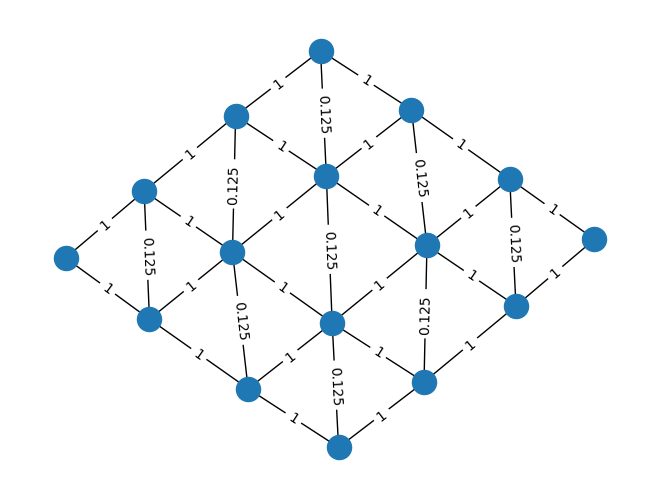

In [19]:
def assign_heisenberg_triangular_labels(graph: Graph, lattice_size:int, j1:float, j2:float) -> None:
    for i in range(lattice_size - 1):
        for j in range(lattice_size - 1):
            graph[(i,j)][(i+1,j)]['weight'] = j1
            graph[(i,j)][(i,j+1)]['weight'] = j1
            graph[(i,j)][i+1,j+1]['weight'] = j2
        graph[(i,lattice_size-1)][(i+1,lattice_size-1)]['weight'] = j1
    for j in range(lattice_size - 1):
        graph[(lattice_size-1,j)][(lattice_size-1,j+1)]['weight'] = j1

def generate_heisenberg_triangular_hamiltonian(lattice_size:int, j1:float, j2:float):
    graph = nx_triangle_lattice(lattice_size)
    assign_heisenberg_triangular_labels(graph, lattice_size, j1, j2)
    flat_graph = flatten_nx_graph(graph)
    H = nx_heisenberg_terms(flat_graph)
    return H

triangular_heisenberg = nx_triangle_lattice(4)
assign_heisenberg_triangular_labels(triangular_heisenberg, 4, 1, 1/8)
pos = spring_layout(triangular_heisenberg)
edge_labels = dict([((n1, n2), d['weight']) for n1, n2, d in triangular_heisenberg.edges(data=True)]);
draw(triangular_heisenberg, pos)
draw_networkx_edge_labels(triangular_heisenberg, pos,edge_labels = edge_labels)

Now that we have the Hamiltonian generated, we need to generate an initial state with non-vanishing overlap with the ground state (or the low energy subspace). This can reasonably be achieved by using mean field methods like Hartree-Fock. This is an advantageous approach since Hartree-Fock will generate a product state, which should be easily prepared using local operations.

We are currently looking for good implementations of Hartree-Fock so we do not currently have this portion incorporated into this notebook. However, this will be implemented in the coming weeks. 

In [20]:
#TODO: Incorporate Hartree-Fock into this section for initial state preparation

At this stage is where we would select a block encoding for our hamiltonian where our encoding is a linear combination of unitaries (LCU). However, as pyLIQTR currently does not support this specific problem instance, we will be specifying instead the parameters needed for performing QPE through a trotterized subprocess. For this problem, we will be using a second order trotterization with a single trotter step. We will be wanting 10 bits of precision, but as it would take a long time to approximate it to that many bits, we will simply scale it up. Formalizing our experiment like this, we can see that the circuit depth scales linearly with the number of trotter steps and exponentially base 2 for the number of bits of precision. This allows us to generate a circuit to estimate the ground state energy of the lattice when tuned to an instability.

In [21]:
bits_precision = 10
trotter_order = 2
trotter_steps = 1

square_pyliqtr_heisenberg = pyH(square_heisenberg_qubit_hamiltonian)
square_qubit_op_heisenberg = pyliqtr_hamiltonian_to_openfermion_qubit_operator(square_pyliqtr_heisenberg)

E_min = -len(square_qubit_op_heisenberg.terms)
E_max = 0
omega = E_max-E_min
t = 2*np.pi/omega
phase_offset = E_max*t

gsee_args = {
    'trotterize' : True,
    'mol_ham'    : square_qubit_op_heisenberg,
    'ev_time'    : t,
    'trot_ord'   : trotter_order,
    'trot_num'   : trotter_steps
}
init_state = [0] * lattice_size * lattice_size * 2 #TODO: use Fock state from Hartree-Fock as initial state

Then, by calling circuit_estimate, we can generate a resource estimate corresponding to this GSEE circuit for a square lattice. 

In [22]:
print(f'Estimating Heisenberg king graph of size {lattice_size}')
t0 = time.perf_counter()
gsee_resource_estimation(
    outdir='GSE/Heisenberg_GSEE/Square/',
    numsteps=trotter_steps,
    gsee_args=gsee_args,
    init_state=init_state,
    precision_order=1,
    bits_precision=bits_precision,
    phase_offset=phase_offset,
    circuit_name=f'square_heisenberg_hamiltonian',
    write_circuits=True
)
t1 = time.perf_counter()
print(f'Time to estimate Heisenberg king graph: {t1-t0}')

Estimating Heisenberg king graph of size 5
Time to generate circuit for GSEE: 6.279104854911566e-05 seconds
   Time to decompose high level HPowGate circuit: 8.887494914233685e-05 seconds 
   Time to transform decomposed HPowGate circuit to Clifford+T: 0.0003006670158356428 seconds
   Time to decompose high level IdentityGate circuit: 1.6708974726498127e-05 seconds 
   Time to transform decomposed IdentityGate circuit to Clifford+T: 4.375004209578037e-06 seconds
   Time to decompose high level PhaseOffset circuit: 0.00012099999003112316 seconds 
   Time to transform decomposed PhaseOffset circuit to Clifford+T: 9.816605597734451e-05 seconds
   Time to decompose high level Trotter_Unitary circuit: 0.08363029104657471 seconds 
   Time to transform decomposed Trotter_Unitary circuit to Clifford+T: 0.6958530839765444 seconds
   Time to decompose high level MeasurementGate circuit: 0.000298250000923872 seconds 
   Time to transform decomposed MeasurementGate circuit to Clifford+T: 3.8874917

We then perform the same experiment but on a triangular lattice 

In [23]:
bits_precision = 10
triangular_lattice_size = 8
triangular_heisenberg = generate_heisenberg_triangular_hamiltonian(triangular_lattice_size, 1, 1/8)
triangular_trotter_steps = 1

triangular_pyliqtr_heisenberg = pyH(triangular_heisenberg)
triangular_qubit_op_heisenberg = pyliqtr_hamiltonian_to_openfermion_qubit_operator(
    triangular_pyliqtr_heisenberg
)

E_min = -len(triangular_qubit_op_heisenberg.terms)
E_max = 0
omega = E_max-E_min
t = 2*np.pi/omega
phase_offset = E_max*t

gsee_args = {
    'trotterize' : True,
    'mol_ham'    : triangular_qubit_op_heisenberg,
    'ev_time'    : t,
    'trot_ord'   : trotter_order,
    'trot_num'   : triangular_trotter_steps
}
init_state = [0]*triangular_lattice_size*triangular_lattice_size*2

In [24]:
print(f'Estimating Heisenberg model on a triangular lattice of size {triangular_lattice_size}')
t0 = time.perf_counter()
gsee_resource_estimation(
    outdir='GSE/Heisenberg_GSEE/Triangular/',
    numsteps=triangular_trotter_steps,
    gsee_args=gsee_args,
    init_state=init_state,
    precision_order=1,
    bits_precision=bits_precision,
    phase_offset=phase_offset,
    circuit_name=f'triangular_heisenberg_hamiltonian',
    write_circuits=True
)
t1 = time.perf_counter()
print(f'Time to estimate Heisenberg on a triangular lattice: {t1-t0}')

Estimating Heisenberg model on a triangular lattice of size 8
Time to generate circuit for GSEE: 0.00012920796871185303 seconds
   Time to decompose high level HPowGate circuit: 8.074997458606958e-05 seconds 
   Time to transform decomposed HPowGate circuit to Clifford+T: 0.0002009579911828041 seconds
   Time to decompose high level IdentityGate circuit: 1.5167053788900375e-05 seconds 
   Time to transform decomposed IdentityGate circuit to Clifford+T: 3.7919962778687477e-06 seconds
   Time to decompose high level PhaseOffset circuit: 8.162495214492083e-05 seconds 
   Time to transform decomposed PhaseOffset circuit to Clifford+T: 8.74160323292017e-05 seconds
   Time to decompose high level Trotter_Unitary circuit: 0.1786704579135403 seconds 
   Time to transform decomposed Trotter_Unitary circuit to Clifford+T: 2.3817522500175983 seconds
   Time to decompose high level MeasurementGate circuit: 0.0005746250972151756 seconds 
   Time to transform decomposed MeasurementGate circuit to Cl

### Validating the Spin Hamiltonian of a Compound and Predicting the Dynamics of an Exotic Quantum Phase


For quantum magnetic materials, a standard measurement to study the magnetic dynamics is inelastic neutron scattering. This measures the lattice-averaged two-point spin correlation functions $<S_i \cdot S_j>$, Fourier transformed in time and space. The objective of this application is to calculate the time-evolved two-point quantum spin correlation function of our J1-J2 Heisenberg model after a local spin flip corresponding to a scattered neutron. The purpose of this is to compare with experimental neutron scattering data to verify or rule out the J1-J2 Heisenberg model.

For this experiment, as the energy precision is so low, i.e, 1e-3, its best to use a second order trotterization evaluation. 

There are four main steps for simulating the time dynamics of our spin model:
1. Prepare ground state or a low energy state $\rho_0$ up to an energy precision of $\frac{|J_1|}{50}$, where $J_1$ is the largest exchange interaction term
2. Flip a randomly chosen spin i
3. Perform Hamiltonian simulation up to time t
4. Measure two-point correlaton $<S_i, S_J>$ for each $j \neq i$ 

To begin orchestrating this, we need to transform the graph shown above to a format that pyLIQTR understands to perform trotterization.

Then, we perform the same experiment but through a second order Trotter expansion.

In [25]:
energy_precision = 1e-3
evolution_time=100
numsteps=68

In [26]:
trotter_cirquit = estimate_trotter(
    openfermion_hamiltonian=triangular_qubit_op_heisenberg,
    evolution_time=evolution_time,
    energy_precision=energy_precision,
    outdir='trotter/triangular_heisenberg/',
    hamiltonian_name='triangular_heisenberg',
    write_circuits=True,
    nsteps=numsteps
)

Time to find term ordering: 0.0012380409752950072 seconds
Time to generate trotter circuit from openfermion: 1.0420335456728935e-06 seconds
Time to generate a clifford + T circuit from trotter circuit: 0.7697882909560576 seconds


Measuring the two-point correlation operators requires observing $S_i \cdot S_j$. This can be done directly by applying the gates CNOT-H-CNOT and then observing in the Z-basis. As such, this is an O(1) operation and will not scale with our resource estimates.